Importing useful libraries and importing the drive for the dataset

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import torch
import torch.nn as nn
import sklearn
import pandas as pd
import io
from sklearn.model_selection import train_test_split

In [33]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My\ Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/My Drive'
/content/drive/My Drive


Importing the data

In [34]:
pddata = pd.read_csv('GSM1586785_ScrH-12A_Exd_14mer_cg.csv.zip', compression='zip', error_bad_lines=False, skiprows=1)

In [35]:
# transforming into a numpy array
pddata = pddata.to_numpy()
# getting the labels as the last column and neglecting the DNA sequence feature
RelKa = pddata[:, -1]
training_data = pddata[:, 2:-1]

Some helpers function for the analysis below

In [36]:
def drop_outliers(x, y, outliers):
  x = np.delete(x, outliers, axis=0)
  y = np.delete(y, outliers, axis=0)
  return x, y

In [37]:
from sklearn import preprocessing

def standardize(x):
  scaler = preprocessing.StandardScaler().fit(training_data)
  x = scaler.transform(x)
  return x

In [38]:
def split_RelKa(y, p):
  return np.array([1 if value > p else 0 for value in y])

In [39]:
from sklearn.ensemble import RandomForestClassifier

def predict_with_Random_Forests(x_train, x_test, y_train, y_test):
  clf = RandomForestClassifier(n_estimators=100, criterion='entropy')
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)  
  return y_pred

In [40]:
from sklearn import metrics

def return_accuracy(y_test, y_pred, verbose=1):
  C = metrics.confusion_matrix(y_test, y_pred)
  accuracy = np.trace(C) / len(y_test)
  if verbose == 1:
    print("The number of true negatives is:", C[0, 0])
    print("The number of false negatives is:", C[1,0])
    print("The number of false positives is:", C[0,1])  
    print("The number of true positives is:", C[1,1])
    print("The accuracy is:", accuracy)
  return accuracy

ISOLATION FORESTS ANOMALY DETECTION

In [41]:
from sklearn.ensemble import IsolationForest

def Anomaly_Detection_Isolation_Forests(x):
  random_state = np.random.RandomState(42)
  contamination = float(0.05)
  model = IsolationForest(n_estimators=120, max_samples='auto', contamination=contamination, random_state=random_state)
  model.fit(x)
  scores = model.decision_function(x)
  anomaly_score = model.predict(x)
  outliers_indices = np.where(anomaly_score == -1)[0] 
  return contamination, scores, outliers_indices

def check_Isolation_Forests(contamination, outliers_indices):
  """
  Simply a check on the proper working of the IF algorithm
  """
  tol = 1.0e-02
  outliers_percentage = 1 / len(RelKa) * len(outliers_indices)
  assert np.abs(contamination-outliers_percentage) < tol

def check_boundary_decision(scores, p, verbose=1):
  """
  This function simply controls how many scores returned by the IF algorithm 
  are likely to be misclassified
  """
  indecision_percentage = 1 / len(RelKa) * np.count_nonzero(np.abs(scores) <= p)
  if verbose == 1:
    plt.hist(scores)
    plt.show()
    print("The indecision percentage around", p,  "is", indecision_percentage)

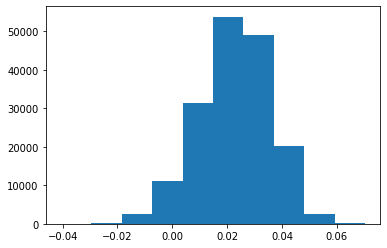

The indecision percentage around 0.02 is 0.39833509203892603


In [42]:
contamination, scores, outliers_indices = Anomaly_Detection_Isolation_Forests(training_data)
check_Isolation_Forests(contamination, outliers_indices)
check_boundary_decision(scores, 0.02, verbose=1)

In [43]:
training_data, RelKa = drop_outliers(training_data, RelKa, outliers_indices)
training_data = standardize(training_data)
RelKa_tilda = split_RelKa(RelKa, 0.5)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(training_data, RelKa_tilda, test_size=0.7, random_state=42)

In [45]:
y_pred = predict_with_Random_Forests(X_train, X_test, y_train, y_test)
accuracy = return_accuracy(y_test, y_pred, verbose=1)

The number of true negatives is: 111801
The number of false negatives is: 755
The number of false positives is: 88
The number of true positives is: 792
The accuracy is: 0.992568496773511


We see that we have a problem with a large number of false negatives, namely with incorrectly predictions of the negative class

A further insight on the errors has to be done, but probably increasing the threshold 0.5 helps already a lot

ONE CLASS SUPPORT VECTOR MACHINE ANOMALY DETECTION

In [93]:
from sklearn.svm import OneClassSVM

def OneClassSVM_Anomaly_Detection(X):
  clf = OneClassSVM(kernel='sigmoid', degree=3, gamma='scale', tol=0.001, nu=0.5, shrinking=True, max_iter=- 1)
  clf.fit(X)
  scores = model.decision_function(x)
  anomaly_score = model.predict(x)
  outliers_indices = np.where(anomaly_score == -1)[0] 
  return scores, outliers_indices

def check_boundary_decision_OCSVM(scores, p, verbose=1):
  indecision_percentage = 1 / len(RelKa) * np.count_nonzero(np.abs(scores) <= p)
  if verbose == 1:
    plt.hist(scores)
    plt.show()
    print("The indecision percentage around", p, "is", indecision_percentage)

In [ ]:
scores, outliers_indices = OneClassSVM_Anomaly_Detection(training_data)
check_boundary_decision_OCSVM(scores, 0.02, verbose=1)

In [ ]:
training_data, RelKa = drop_outliers(training_data, RelKa, outliers_indices)
training_data = standardize(training_data)
RelKa_tilda = split_RelKa(RelKa, 0.5)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(training_data, RelKa_tilda, test_size=0.7, random_state=42)

In [ ]:
y_pred = predict_with_Random_Forests(X_train, X_test, y_train, y_test)
accuracy = return_accuracy(y_test, y_pred, verbose=1)